##Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

##Load Datasets

In [26]:
# Load datasets
data = pd.read_csv('data_diseases.csv')
#data_alzheimer_income = pd.read_csv('alzheimer_income_data.csv')
#ata_alzheimer_healthcare = pd.read_csv('alzheimer_healthcare_data.csv')

In [27]:
print(data.describe())

              year       PM2.5          CVD  Alzheimers_and_other_dementias  \
count   560.000000  560.000000   560.000000                      560.000000   
mean   2009.642857   27.381786   368.159643                      134.369643   
std       8.598433   23.948261   598.319050                      105.330706   
min    1990.000000    5.260000    12.530000                       10.680000   
25%    2005.000000    8.130000    42.337500                       42.805000   
50%    2012.500000   14.880000   111.970000                      112.565000   
75%    2016.000000   36.680000   411.485000                      201.110000   
max    2019.000000   95.240000  2712.330000                      522.700000   

               CRD  Diabetes_and_Kidney  
count   560.000000           560.000000  
mean    365.330446           206.057339  
std     600.605491           324.196392  
min       7.850000            14.400000  
25%      52.660000            30.727500  
50%     110.045000            83.830

##Basic EDA

###Correlation Matrix and Heatmap

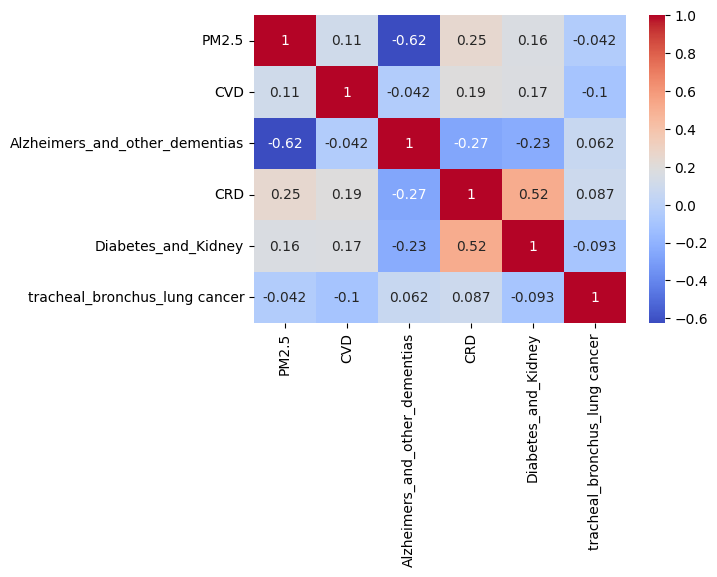

In [28]:
# Columns that need to be converted
columns_to_convert = ['PM2.5', 'CVD', 'Alzheimers_and_other_dementias', 'CRD', 'Diabetes_and_Kidney', 'tracheal_bronchus_lung cancer']

# Remove commas and convert to float
for column in columns_to_convert:
    data[column] = data[column].replace(',', '', regex=True).astype(float)

# Select only the numerical columns necessary for the correlation heatmap
numerical_data = data[columns_to_convert]

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Plotting the heatmap with a smaller size and a new color palette
plt.figure(figsize=(6, 4))  # Smaller figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')  # Changed to 'coolwarm' for a blue-orange color scheme
plt.show()

Observations from the Heatmap:
PM2.5 and Alzheimer's Disease: There is a significant negative correlation (-0.62), suggesting that higher PM2.5 levels are associated with lower DALYs for Alzheimer's and other dementias. This is counterintuitive, as one might expect higher pollution to potentially exacerbate health issues, including neurological ones. This unexpected correlation could be influenced by various factors such as demographic differences, underdiagnosis in areas with high pollution, or other confounding environmental or health system factors.

PM2.5 and Chronic Respiratory Diseases (CRD): There is a positive correlation (0.25) with CRD, which aligns with conventional understanding that higher pollution increases respiratory ailments. This correlation suggests a possible direct relationship where higher PM levels might contribute to higher DALYs for CRD, although causality would still need to be determined through more detailed analysis.

PM2.5 and Other Diseases:

Diabetes and Kidney Diseases: There's a positive correlation (0.16), though it is relatively weaker. This suggests some level of association but isn't as strong as with CRD.
Tracheal, Bronchus, Lung Cancer: The correlation is very low (-0.042), suggesting almost no direct relation between PM2.5 levels and the DALYs for these cancers in the data observed.
Can We Claim Causation?
Claiming causation solely based on these correlations would be premature and potentially misleading. While the data suggests that higher PM2.5 levels might be associated with higher DALYs for some diseases (like CRD), and lower for others (like Alzheimer’s), these are observational correlations that might be influenced by many other unmeasured factors.
Statistical Testing and Further Analysis: To rigorously test if an increase in PM values causes an increase in DALYs, you would need to perform statistical tests that account for potential confounders, perhaps using models like regression analysis with controls for various socio-demographic and economic factors.
Longitudinal Data: Analysis over time, controlling for changes in healthcare access, population age, and other health policies, would provide stronger evidence towards causation.
Conclusion:
Based on the current analysis, it's reasonable to hypothesize that PM2.5 may contribute to an increase in DALYs for most diseases except Alzheimer’s, as suggested by the negative correlation. However, asserting a causal relationship requires more thorough investigation beyond correlation, including potential longitudinal studies, experimental designs, or more advanced statistical modeling to control for other variables. For Alzheimer's, particularly, further research would be necessary to understand the underlying reasons for the negative correlation observed and to rule out confounding factors.

##Data cleaning

In [29]:
# Display the first few rows of the dataframe
print(data.head())

# Check for duplicates and remove them
print(f'Number of duplicate rows: {data.duplicated().sum()}')
data = data.drop_duplicates()

# Display the shape of the dataframe after removing duplicates
print(data.shape)

    country   year  PM2.5     Sex     CVD  Alzheimers_and_other_dementias  \
0  Australia  1990   7.59    Male  296.99                           56.82   
1  Australia  1990   7.59  Female  209.43                          126.54   
2  Australia  1995   7.48    Male  235.54                           64.90   
3  Australia  1995   7.48  Female  170.51                          148.55   
4  Australia  2000   7.36    Male  195.89                           77.91   

     CRD  Diabetes_and_Kidney  tracheal_bronchus_lung cancer  
0  43.18               101.64                          96.99  
1  13.92                35.69                          32.10  
2  47.69               113.57                         113.32  
3  15.51                40.06                          31.94  
4  50.46               127.32                         129.36  
Number of duplicate rows: 0
(560, 9)


##Data splitting

In [30]:
from sklearn.model_selection import train_test_split

# Define the target variable and features
target = 'Alzheimers_and_other_dementias'
features = data.drop(columns=[target])

# Split the data into training and testing sets in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data[target],
    test_size=0.2,
    random_state=42,

)

# Display the shapes of the resulting datasets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(448, 8) (112, 8)
(448,) (112,)


###outliers detection

In [31]:
# Select only numeric columns for outlier detection
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]

# Function to detect outliers using Z-score
def detect_outliers(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    outliers = (z_scores > threshold).any(axis=1)
    return df[outliers]

# Detect outliers in the training set
outliers = detect_outliers(X_train_numeric)
print(f'Number of outliers detected: {outliers.shape[0]}')

# Display some of the detected outliers
print(outliers.head())



Number of outliers detected: 61
     year  PM2.5      CVD      CRD  Diabetes_and_Kidney  \
497  2016  30.69   637.25  1415.10              1361.80   
54   2019  63.43    41.44  2546.69               404.79   
46   2015  68.97    34.95  2781.61               397.10   
494  2015  28.04   855.09  1981.05              1612.48   
481  2000  34.53  1329.16  1162.18              1442.50   

     tracheal_bronchus_lung cancer  
497                          80.80  
54                          610.15  
46                          702.58  
494                          88.51  
481                         142.84  


###Data distribution

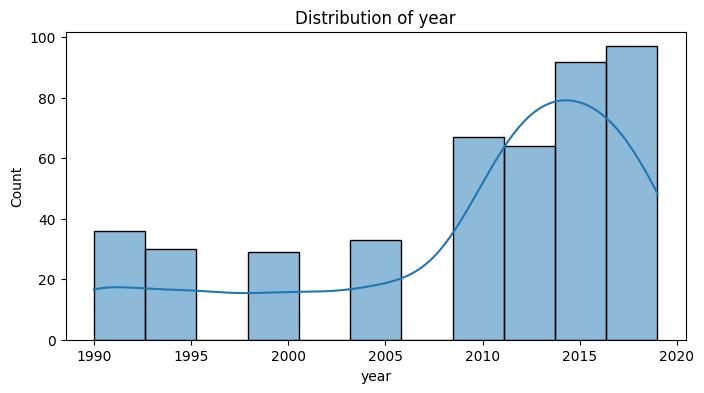

Normality test for year: p-value=7.218390064696038e-14


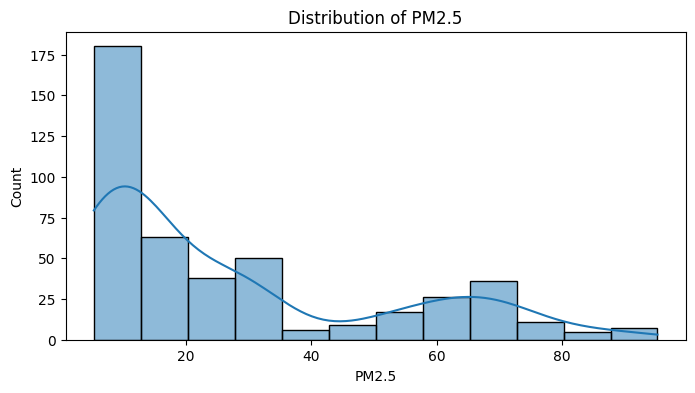

Normality test for PM2.5: p-value=1.0112292692449947e-13


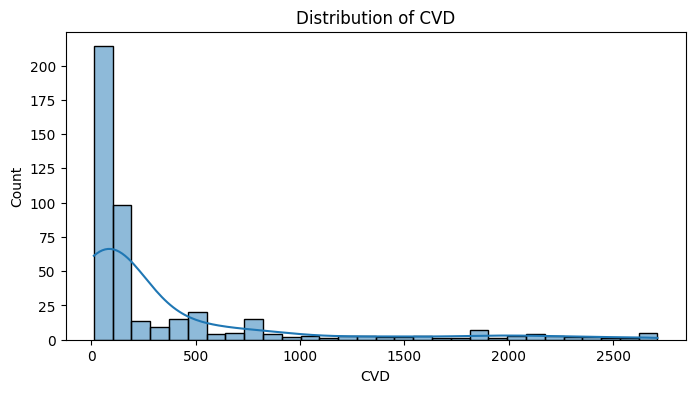

Normality test for CVD: p-value=3.813998634309027e-50


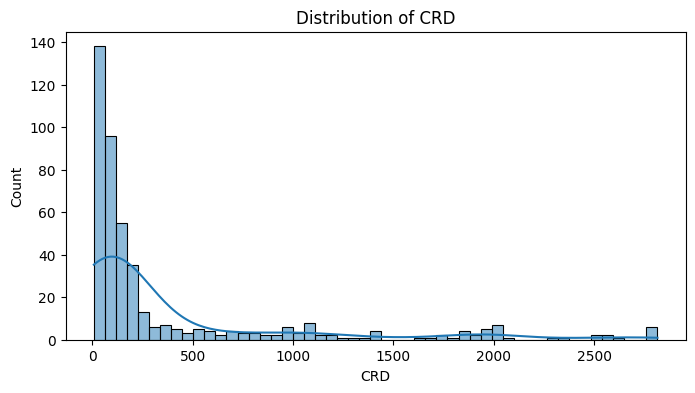

Normality test for CRD: p-value=7.248651182316231e-48


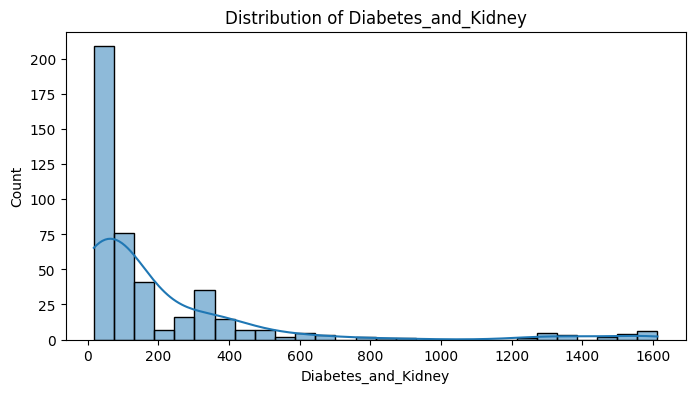

Normality test for Diabetes_and_Kidney: p-value=4.905519285858287e-65


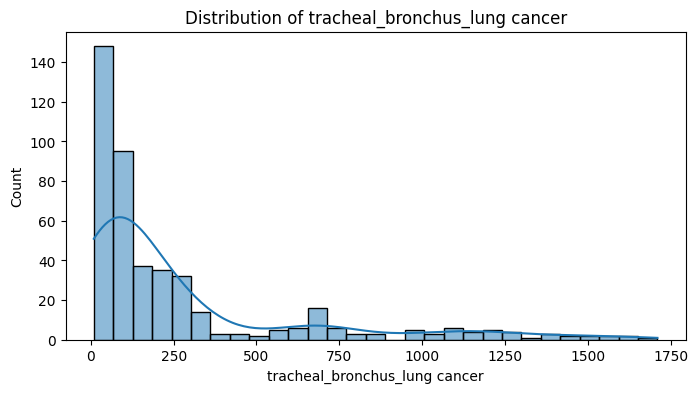

Normality test for tracheal_bronchus_lung cancer: p-value=4.8352314523877086e-40


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest

# Check the distribution of each numeric feature in the training set
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

    # Perform a normality test
    stat, p = normaltest(X_train[column].dropna())
    print(f'Normality test for {column}: p-value={p}')


###Standardization

In [33]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train_numeric)

# Transform the test data
X_test_numeric = X_test[numeric_columns]
X_test_scaled = scaler.transform(X_test_numeric)

# Convert the scaled data back to DataFrames for ease of use
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_columns)

# Display the first few rows of the scaled training data
print(X_train_scaled.head())


       year     PM2.5       CVD       CRD  Diabetes_and_Kidney  \
0  0.625174  0.044715  0.237374 -0.446981             1.298149   
1  0.395225 -0.890365 -0.383061 -0.513868            -0.272778   
2 -2.249189 -0.831193 -0.097412 -0.538322            -0.319899   
3  0.165276 -0.867863 -0.438822 -0.557386            -0.507630   
4 -0.524571 -0.644927 -0.527221 -0.221752            -0.548625   

   tracheal_bronchus_lung cancer  
0                       0.091507  
1                      -0.476123  
2                      -0.479480  
3                      -0.629946  
4                       0.512469  


##Modeling

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Initialize the models
linear_reg = LinearRegression()
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)

# Train the models on the scaled training data
linear_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred_linear = linear_reg.predict(X_test_scaled)
y_pred_tree = decision_tree.predict(X_test_scaled)
y_pred_forest = random_forest.predict(X_test_scaled)

# Calculate RMSE for each model
rmse_linear = calculate_rmse(y_test, y_pred_linear)
rmse_tree = calculate_rmse(y_test, y_pred_tree)
rmse_forest = calculate_rmse(y_test, y_pred_forest)

# Print RMSE results
print(f'Linear Regression RMSE: {rmse_linear}')
print(f'Decision Tree RMSE: {rmse_tree}')
print(f'Random Forest RMSE: {rmse_forest}')


Linear Regression RMSE: 78.40564197134597
Decision Tree RMSE: 45.44700952758058
Random Forest RMSE: 30.805702672687655


###Hyperparameter tuning for decision tree and random forest

In [35]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Decision Tree
param_grid_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(decision_tree, param_grid_tree, cv=3)
grid_search_tree.fit(X_train_scaled, y_train)

# Best parameters and RMSE for Decision Tree
best_tree = grid_search_tree.best_estimator_
y_pred_best_tree = best_tree.predict(X_test_scaled)
rmse_best_tree = calculate_rmse(y_test, y_pred_best_tree)

print(f'Best Decision Tree Parameters: {grid_search_tree.best_params_}')
print(f'Best Decision Tree RMSE: {rmse_best_tree}')

# Hyperparameter tuning for Random Forest
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_forest = GridSearchCV(random_forest, param_grid_forest, cv=3)
grid_search_forest.fit(X_train_scaled, y_train)

# Best parameters and RMSE for Random Forest
best_forest = grid_search_forest.best_estimator_
y_pred_best_forest = best_forest.predict(X_test_scaled)
rmse_best_forest = calculate_rmse(y_test, y_pred_best_forest)

print(f'Best Random Forest Parameters: {grid_search_forest.best_params_}')
print(f'Best Random Forest RMSE: {rmse_best_forest}')


Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Decision Tree RMSE: 46.63761353807754
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest RMSE: 30.805702672687655


##Additional Model

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Train the model on the scaled training data
gradient_boosting.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred_gb = gradient_boosting.predict(X_test_scaled)

# Calculate RMSE for the Gradient Boosting Regressor
rmse_gb = calculate_rmse(y_test, y_pred_gb)

# Print RMSE results
print(f'Gradient Boosting Regressor RMSE: {rmse_gb}')


Gradient Boosting Regressor RMSE: 32.608206278408204


###Hyperparameter tuning for gradient Boosting regressor

In [37]:
# Hyperparameter tuning for Gradient Boosting Regressor
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=3)
grid_search_gb.fit(X_train_scaled, y_train)

# Best parameters and RMSE for Gradient Boosting
best_gb = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test_scaled)
rmse_best_gb = calculate_rmse(y_test, y_pred_best_gb)

print(f'Best Gradient Boosting Parameters: {grid_search_gb.best_params_}')
print(f'Best Gradient Boosting RMSE: {rmse_best_gb}')


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Gradient Boosting RMSE: 23.608140541500795
